<a href="https://colab.research.google.com/github/RobertShehu/Colab/blob/main/VMMR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import os
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

In [3]:
IMG_SIZE = 224
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)
path = '/content/drive/MyDrive/'
class_names = os.listdir(path+'Progetto')
depth = len(class_names)

In [4]:
ds_train = tf.keras.preprocessing.image_dataset_from_directory(
    path+'Progetto',
    labels='inferred',
    label_mode="int",
    color_mode="rgb",
    batch_size=BATCH_SIZE,
    image_size=(IMG_SIZE, IMG_SIZE),
    shuffle=True,
    seed=123,
    validation_split=0.1,
    subset='training'
)

ds_validation = tf.keras.preprocessing.image_dataset_from_directory(
    path+'Progetto',
    labels='inferred',
    label_mode="int",
    color_mode="rgb",
    batch_size=BATCH_SIZE,
    image_size=(IMG_SIZE, IMG_SIZE),
    shuffle=True,
    seed=123,
    validation_split=0.1,
    subset='validation'
)

Found 8667 files belonging to 23 classes.
Using 7801 files for training.
Found 8667 files belonging to 23 classes.
Using 866 files for validation.


In [5]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.RandomRotation(1),
  tf.keras.layers.RandomContrast(0.2)
])

base_model = tf.keras.applications.MobileNet(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')

global_average_layer = tf.keras.layers.Flatten()

prediction_layer = keras.layers.Dense(depth, activation='softmax')

model = tf.keras.Sequential([
  data_augmentation,
  base_model,
  global_average_layer,
  prediction_layer
])

17235968/17225924 [==============================] - 0s 0us/step


In [6]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('final_model.h5', monitor="val_accuracy", mode="max", save_best_only=True, verbose=1)
earlystop = tf.keras.callbacks.EarlyStopping(monitor="val_loss", restore_best_weights=True, patience=8, verbose=1)

callbacks = [checkpoint]

In [7]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [8]:
validation_steps = 20
loss0, accuracy0 = model.evaluate(ds_validation, steps=validation_steps)

20/20 [==============================] - 145s 5s/step - loss: 4.7314 - accuracy: 0.0359


In [9]:
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 flatten (Flatten)           (None, 50176)             0         
                                                                 
 dense (Dense)               (None, 23)                1154071   
                                                                 
Total params: 4,382,935
Trainable params: 4,361,047
Non-trainable params: 21,888
_________________________________________________________________
None


In [10]:
initial_epochs = 40
history = model.fit(ds_train, epochs=initial_epochs, validation_data=ds_validation, callbacks=callbacks)
acc = history.history['accuracy']
print(acc)
model.save("model.h5")

Epoch 1/40
244/244 [==============================] - ETA: 0s - loss: 5.3843 - accuracy: 0.0969
Epoch 1: val_accuracy improved from -inf to 0.11894, saving model to final_model.h5
244/244 [==============================] - 1123s 4s/step - loss: 5.3843 - accuracy: 0.0969 - val_loss: 4.4836 - val_accuracy: 0.1189
Epoch 2/40
244/244 [==============================] - ETA: 0s - loss: 2.6498 - accuracy: 0.2170
Epoch 2: val_accuracy improved from 0.11894 to 0.22517, saving model to final_model.h5
244/244 [==============================] - 49s 199ms/step - loss: 2.6498 - accuracy: 0.2170 - val_loss: 3.1807 - val_accuracy: 0.2252
Epoch 3/40
244/244 [==============================] - ETA: 0s - loss: 2.2092 - accuracy: 0.3396
Epoch 3: val_accuracy improved from 0.22517 to 0.28753, saving model to final_model.h5
244/244 [==============================] - 50s 201ms/step - loss: 2.2092 - accuracy: 0.3396 - val_loss: 3.0814 - val_accuracy: 0.2875
Epoch 4/40
244/244 [==============================] -

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


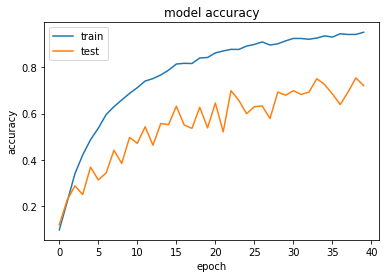

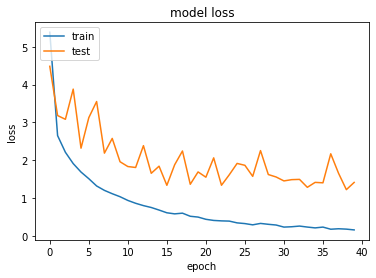

In [11]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
model_dir="/content/final_model.h5"
cars_model=tf.keras.models.load_model(model_dir)
converter = tf.lite.TFLiteConverter.from_keras_model(cars_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

with open('new_cars_model.tflite', 'wb') as f:
  f.write(tflite_model)

In [ ]:
model_dir="/content/model.h5"
cars_model=tf.keras.models.load_model(model_dir)
converter = tf.lite.TFLiteConverter.from_keras_model(cars_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

with open('cars_model.tflite', 'wb') as f:
  f.write(tflite_model)

In [ ]:
cars_model = tf.keras.models.load_model("/content/drive/MyDrive/Modelli/final_model.h5")

In [ ]:
classes = ds_train.class_names
print(classes)
element, label = ds_validation.as_numpy_iterator().next()

In [ ]:
predictions = cars_model.predict(element)
for i in range(32):
  plt.figure()
  fig = element[i]/255.0
  plt.imshow(fig)
  pred_class = classes[np.argmax(predictions[i])]
  true_class = classes[label[i]]
  if (pred_class == true_class):
    print(pred_class+" "+str(np.max(predictions[i])*100)+"%: OK")
  else:
    print(pred_class+" "+str(np.max(predictions[i])*100)+"%: NO, it's a "+true_class)